
#Why Dopamine?
Existing reinforcement learning frameworks are not flexible. It takes time to make changes, and this kind of research requires rapid experimentation

#  Framework Features

## Agents

### DQN

![alt text](http://shws.cc.oita-u.ac.jp/shibata/KissSystem.png)

###  C51
- Basically it is a good old Deep-Q network. But instead of approximating expected future reward values it generates the whole distributions over possible outcomes.
-They’ve done it by replacing the output of DQN with probabilities over categorical variables representing different reward values ranges.

### Rainbow
- Six extensions to the DQN algorithm 

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/0ab3f7ecbdc5a33565a234215604a6ca9d155a33/6-Figure3-1.png)

### Implicit Quantile (Very New)

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/57f85af87e42f1a3d6e74d85a386073049f6586f/4-Figure1-1.png)

- Approximates the full quantile function for the state-action return distribution

## Atari (Environment, wraps OpenAI's gym)

- 60 Atari Environments at https://gym.openai.com/envs/#atari 

## Common (logging, checkpointing)

- Dopamine will save an experiment checkpoint every iteration: one training and one evaluation phase
- Checkpoint 1: Experiment statistics (number of iterations performed, learning curves, etc.)
- Checkpoint 2: Agent variables, including the tensorflow graph.
- Checkpoint 3: Replay buffer data. Atari 2600 replay buffers have a large memory footprint, this prevents that
-It also records the agent's performance, both during training and (if enabled) during an optional evaluation phase. 

## Replay Memory (several neatly wrapped functions)

- Circular Replay
- Prioritized Replay
- Sum Tree

## Tests

- Self explanatory

# Markov Decision Processes

![alt text](https://image.slidesharecdn.com/ml-sep-09-091009141615-phpapp01/95/regretbased-reward-elicitation-for-markov-decision-processes-39-728.jpg?cb=1255098159)

![alt text](https://i.stack.imgur.com/QNV7Z.jpg)

# Policies

![alt text](https://image.slidesharecdn.com/deepreinforcementlearningfromscratch1-171221153614/95/deep-reinforcement-learning-from-scratch-29-638.jpg?cb=1513870627)

- A policy describes a way of acting. 
- It is a function that takes in a state and an action and returns the probability of taking that action in that state.
- Our goal in reinforcement learning is to learn an optimal policy
- An optimal policy is a policy which tells us how to act to maximize return in every state.

# Value Functions

![alt text](https://slideplayer.com/slide/4757729/15/images/10/Grid+world+Optimal+policy+when+R%28s%29+%3D+for+every+non-terminal+state.jpg)

- To learn the optimal policy, we make use of value functions. 
- There are two types of value functions that are used in reinforcement learning: 
- the state value function, denoted V(s), and the action value function, denoted Q(s, a).
- The state value function describes the value of a state when following a policy. It is the expected return when starting from state s acting according to our policy 

![alt text](https://joshgreaves.com/wp-content/ql-cache/quicklatex.com-814f9fadd2ab8ee9cb85e12999a17eec_l3.svg)

- The action value function tells us the value of taking an action in some state when following a certain policy. It is the expected return given the state and action 

![alt text](https://joshgreaves.com/wp-content/ql-cache/quicklatex.com-5171067fa940af561a4eebe7d3c2d190_l3.svg)

# The Bellman Equations

- There are 4 Bellman Equations, lets discuss just 2
- Theres a Bellman Equation for the state value function and one for the action value function
- The Bellman equations let us express values of states as values of other states. 
- This means that if we know the value of s_{t+1}, we can very easily calculate the value of s_t. 
- This opens a lot of doors for iterative approaches for calculating the value for each state
- Since if we know the value of the next state, we can know the value of the current state.
- The Bellman Equation characterizes the optimal values, dynamic programming (+ other methods) help compute them

![alt text](https://images.slideplayer.com/16/4958328/slides/slide_18.jpg)

In [1]:
# @title Install necessary packages.
#dopamine for RL
!pip install --upgrade --no-cache-dir dopamine-rl
# dopamine dependencies
!pip install cmake
#Arcade Learning Environment
!pip install atari_py

    100% |████████████████████████████████| 71kB 2.9MB/s 
    100% |████████████████████████████████| 1.5MB 61.0MB/s 
    100% |████████████████████████████████| 1.0MB 56.5MB/s 
  Running setup.py install for gym ... - \ | done
    100% |████████████████████████████████| 17.7MB 712kB/s 
    100% |████████████████████████████████| 768kB 20.5MB/s 
  Running setup.py bdist_wheel for atari-py ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Sto

In [0]:
# @title Necessary imports and globals.
#matrix math
import numpy as np
#load files
import os
#DQN for baselines
from dopamine.agents.dqn import dqn_agent
#high level agent-environment excecution engine
from dopamine.atari import run_experiment
#visualization + data downloading
from dopamine.colab import utils as colab_utils
#warnings
from absl import flags

#where to store training logs
BASE_PATH = '/tmp/colab_dope_run'  # @param
#which arcade environment?
GAME = 'Asterix'  # @param

In [0]:
# @title Create a  new agent from scratch.

#define where to store log data
LOG_PATH = os.path.join(BASE_PATH, 'basic_agent', GAME)

class BasicAgent(object):
  """This agent randomly selects an action and sticks to it. It will change
  actions with probability switch_prob."""
  def __init__(self, sess, num_actions, switch_prob=0.1):
    #tensorflow session
    self._sess = sess
    #how many possible actions can it take?
    self._num_actions = num_actions
    # probability of switching actions in the next timestep?
    self._switch_prob = switch_prob
    #initialize the action to take (randomly)
    self._last_action = np.random.randint(num_actions)
    #not debugging
    self.eval_mode = False
  
  #How select an action? 
  #we define our policy here
  def _choose_action(self):
    if np.random.random() <= self._switch_prob:
      self._last_action = np.random.randint(self._num_actions)
    return self._last_action
    
  #when it checkpoints during training, anything we should do?
  def bundle_and_checkpoint(self, unused_checkpoint_dir, unused_iteration):
    pass
    
  #loading from checkpoint
  def unbundle(self, unused_checkpoint_dir, unused_checkpoint_version,
               unused_data):
    pass
  
  #first action to take
  def begin_episode(self, unused_observation):
    return self._choose_action()
  
  #cleanup
  def end_episode(self, unused_reward):
    pass
  
  #we can update our policy here
  #using the reward and observation
  #dynamic programming, Q learning, monte carlo methods, etc.
  def step(self, reward, observation):
    return self._choose_action()
  
def create_basic_agent(sess, environment):
  """The Runner class will expect a function of this type to create an agent."""
  return BasicAgent(sess, num_actions=environment.action_space.n,
                     switch_prob=0.2)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework. We also explicitly terminate after 110 iterations (instead
# of the standard 200) to demonstrate the plotting of partial runs.
basic_runner = run_experiment.Runner(LOG_PATH,
                                      create_basic_agent,
                                      game_name=GAME,
                                      num_iterations=200,
                                      training_steps=10,
                                      evaluation_steps=10,
                                      max_steps_per_episode=100)

In [5]:
# @title Train Basic Agent.
print('Will train basic agent, please be patient, may be a while...')
basic_runner.run_experiment()
print('Done training!')

Will train basic agent, please be patient, may be a while...
INFO:tensorflow:Beginning training...
INFO:tensorflow:Starting iteration 0
INFO:tensorflow:Average undiscounted return per training episode: 200.00
INFO:tensorflow:Average training steps per second: 739.24
INFO:tensorflow:Average undiscounted return per evaluation episode: 50.00
INFO:tensorflow:Starting iteration 1
INFO:tensorflow:Average undiscounted return per training episode: 100.00
INFO:tensorflow:Average training steps per second: 710.93
INFO:tensorflow:Average undiscounted return per evaluation episode: 50.00
INFO:tensorflow:Starting iteration 2
INFO:tensorflow:Average undiscounted return per training episode: 100.00
INFO:tensorflow:Average training steps per second: 728.91
INFO:tensorflow:Average undiscounted return per evaluation episode: 150.00
INFO:tensorflow:Starting iteration 3
INFO:tensorflow:Average undiscounted return per training episode: 100.00
INFO:tensorflow:Average training steps per second: 739.07
INFO:t

In [0]:
# @title Load baseline data
!gsutil -q -m cp -R gs://download-dopamine-rl/preprocessed-benchmarks/* /content/
experimental_data = colab_utils.load_baselines('/content')

In [7]:
# @title Load the training logs.
basic_data = colab_utils.read_experiment(log_path=LOG_PATH, verbose=True)
basic_data['agent'] = 'BasicAgent'
basic_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(basic_data,
                                                        how='outer')

Reading statistics from: /tmp/colab_dope_run/basic_agent/Asterix//logs/log_199


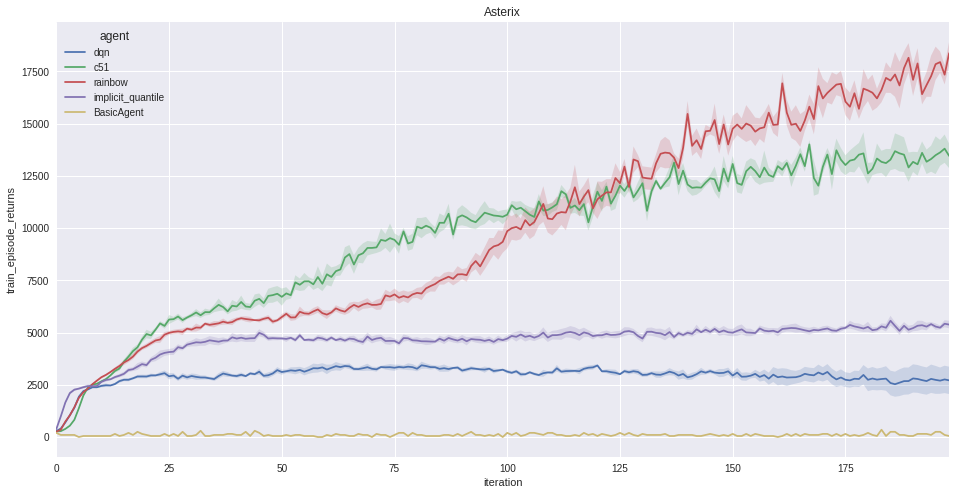

In [8]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=experimental_data[GAME], time='iteration', unit='run_number',
           condition='agent', value='train_episode_returns', ax=ax)
plt.title(GAME)
plt.show()